# Visualising outbreak curves

## Reading and cleaning  the data

Import things

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import os
import pylab as plt
import geopandas as gpd
import adjustText as aT
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from glob import glob


In [3]:
from os.path import isfile, join
path = '/Users/sophieayling/Library/CloudStorage/OneDrive-UniversityCollegeLondon/GitHub/Disease-Modelling-SSA/data/'
path_raw = '/Users/sophieayling/Library/CloudStorage/OneDrive-UniversityCollegeLondon/GitHub/Disease-Modelling-SSA/data/raw'
path_output = '/Users/sophieayling/Library/CloudStorage/OneDrive-UniversityCollegeLondon/GitHub/Disease-Modelling-SSA/data/output/direct_output/'

#below the paths for WB computer
# path = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/"
# path_raw = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/raw/"
# path_output = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/direct_output/"

COMPARE TO [this](https://ourworldindata.org/covid-deaths)

## 1. Plotting the Ordering of Districts

### Observing while running

Progress can be observed as they're running - just add the file to which the simulation is exporting below!

**NOTE: MAKE SURE YOU HAVE A TEXT FILE IN THE SAME DIRECTORY AS THIS FILE CONTAINING THE 'TRUE' ORDER OF FILES!**

This file should be formatted as follows:

```
day	districtId
1	1
1	2
...
```

Please note that it is TAB DELIMITED - if your data is not, then you will need to update the csv readin below.

In [7]:
# set my path when running the file from here

# read and clean the data
results_filename = (path_output+'exportMe3324_016_180_5timescases.txt')
output_filename = ('1017_180_016_50p')
r_data = pd.read_csv(results_filename, sep='\t')
r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]] # she is renaming districtid myId
r_data.head()


,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,Unnamed: 8,districtId
0,0,d_38,0,0,0,0,0,0,NaN,38
1,0,d_39,0,0,0,0,0,0,NaN,39
2,0,d_47,0,0,0,0,0,0,NaN,47
3,0,d_48,0,0,0,7,3,0,NaN,48
4,0,d_45,0,0,0,0,0,0,NaN,45


In [8]:
r_data.describe()

,time,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,Unnamed: 8,districtId
count,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,0.0,9660.000000
mean,80.000000,0.001035,0.001242,0.000207,0.019669,0.027536,0.000104,NaN,30.500000
std,46.478206,0.032159,0.035225,0.014388,0.345390,0.346947,0.010174,NaN,17.318999
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000
25%,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,15.750000
50%,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,30.500000
75%,120.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,45.250000
max,160.000000,1.000000,1.000000,1.000000,26.000000,25.000000,1.000000,NaN,60.000000


## 2. First day cases by district comparison

In [11]:

# filter out case data
cases = r_data[(r_data.metric_new_cases_sympt > 0) | (r_data.metric_new_cases_asympt > 0)]
cases.head()

# group by districts and sort by time
byDistric = cases.groupby('districtId').agg({'time': 'min'})
byDistric.sort_values(by="time")

# sophie adding want to rename 'time' to denote the day of simulation
byDistric.rename(columns={'time':'simDay'}, inplace=True)

byDistric.head()

# read in the first districts cases data (what she called 'gold standard data')
gold_filename = ("/Users/sophieayling/Library/CloudStorage/OneDrive-UniversityCollegeLondon/GitHub/Disease-Modelling-SSA/data/preprocessed/line_list/true.txt")
g_data = pd.read_csv(gold_filename, sep='\t')
g_data["trueDay"] = [int(x) for x in g_data['day']] ## Sophie not using this 

# join the simulated and gold standard data based on the district ID
comparison = pd.merge(g_data, byDistric, on='districtId', how='outer', validate='one_to_one')
comparison['simDay'] = comparison['simDay'].fillna(0) # you may wish to set the unfound districts to some default
comparison['trueDay']= comparison['trueDay'].fillna(0)
#comparison # show the results
comparison.head()
comparison.to_csv(path+'comparison.csv')

In [12]:
myslice = pd.isna(comparison['simDay']) # see all of the districts where there were cases in both sim and true days 
#print(comparison[-myslice]) # showing the districts where the cases occured in both simulation and true data
both_sa= comparison[-myslice]
myslice.head()

0    False
1    False
2    False
3    False
4    False
Name: simDay, dtype: bool

/opt/anaconda3/envs/covid19_abm/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='trueDay', ylabel='simDay'>

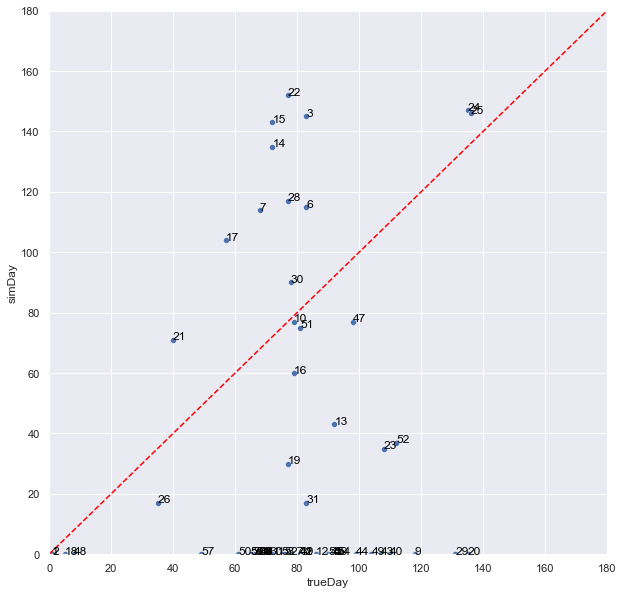

In [14]:
fig, ax = plt.subplots (figsize = (10,10))
ax= sns.scatterplot(
             x="trueDay", 
             y="simDay",
             #y="metric_new_hospitalized",
             #y="metric_new_cases_sympt", 
             palette="colorblind", 
            # hue="districtId",
             data=comparison, #,
            #legend=True
            )
            #.legend(bbox_to_anchor= (1.03, 1) )
            
 # add labels to values on district id
for line in range(0,comparison.shape[0]):
    ax.text(comparison.trueDay[line] +0.01, comparison.simDay[line],
           comparison.districtId[line], horizontalalignment='left',
           size='medium', color='black', weight ='light')

ax.set(xlim=(0, 180), ylim=(0, 180)) # in true day the max first day is 136, in sim the max first day is 179
xl, yl = [0,180], [0,180]
sns.lineplot(xl, yl, linestyle='--', color='red')


#plt.savefig(path+'plots/sim_vs_true_firstcases_'+output_filename+'.png', dpi=300,  facecolor='w', edgecolor='w', transparent=True)



0.030693351357909293

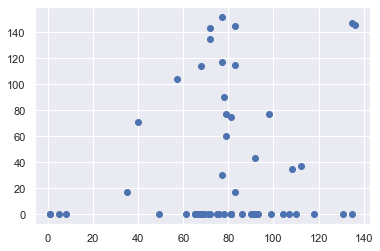

In [15]:
#convert points to format that can be plotted for Rsquared calculation
x=comparison['trueDay']
x.to_dict()
y=comparison['simDay']
y.to_dict()

# plot with R-Squared

plt.scatter(x,y)


#fit the line 
model = np.polyfit(x,y,1)
model
predict = np.poly1d(model)
r2_score(y, predict(x))
# pretty poor rsquared at present 

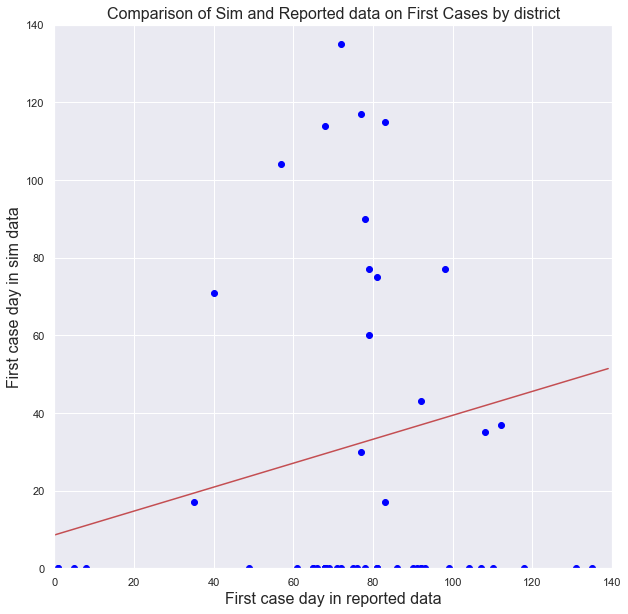

In [16]:
#visualize the plot
x_lin_reg = range(0,140)
y_lin_reg = predict(x_lin_reg)
plt.scatter(x,y, color='blue')
plt.plot(x_lin_reg, y_lin_reg, c='r')
plt.title("Comparison of Sim and Reported data on First Cases by district", loc='center', size=16)
plt.xlabel('First case day in reported data', size = 16)
plt.ylabel('First case day in sim data', size = 16)

#limit range on axis
plt.xlim([0, 140])
plt.ylim([0, 140])

# add labels to values on district id
for line in range(0,comparison.shape[0]):
    ax.text(comparison.trueDay[line] +0.01, comparison.simDay[line],
           comparison.districtId[line], horizontalalignment='left',
           size='medium', color='black', weight ='light')
    

# change dimensions of fig size
plt.gcf().set_size_inches(10, 10)
    
#plt.savefig(path+'plots/sim_vs_true_firstcases_rsq_'+output_filename+'.png', dpi=300,  facecolor='w', edgecolor='w', transparent=True)


## 2. Total cases and deaths by DISTRICT comparison 

In [17]:
# Create a dataset of the total number of cases by district and by day in sim

# create a scaled up variable of cases and deaths x20
r_data['scaled_sim_cases']=r_data['metric_new_cases_sympt'] *2
r_data['scaled_sim_deaths']=r_data['metric_new_deaths' ] *2
r_data['scaled_cum_deaths']=r_data['metric_died_count']*2

r_data.head()

,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,Unnamed: 8,districtId,scaled_sim_cases,scaled_sim_deaths,scaled_cum_deaths
0,0,d_38,0,0,0,0,0,0,NaN,38,0,0,0
1,0,d_39,0,0,0,0,0,0,NaN,39,0,0,0
2,0,d_47,0,0,0,0,0,0,NaN,47,0,0,0
3,0,d_48,0,0,0,7,3,0,NaN,48,6,0,0
4,0,d_45,0,0,0,0,0,0,NaN,45,0,0,0


In [18]:

cases_by_dist = r_data.groupby(['districtId']).agg({'metric_new_cases_sympt':np.sum, 'scaled_sim_cases':np.sum, 'metric_died_count':np.sum, 'scaled_cum_deaths':np.sum})
cases_by_dist['metric_died_count']=cases_by_dist['metric_died_count'].astype(int)
cases_by_dist.to_csv(path_output+'cases_dist_50perc.csv')
cases_by_dist.head()


,metric_new_cases_sympt,scaled_sim_cases,metric_died_count,scaled_cum_deaths
districtId,,,,
1,14,28,0,0
2,100,200,0,0
3,1,2,0,0
4,0,0,0,0
5,0,0,0,0


In [20]:
# join it with the true data district cases and deaths by day

cases_by_dist.sort_values(by='districtId')

# rename metric_new_cases col to denote it is by district by day for each seed
cases_by_dist.rename(columns={'metric_new_cases_sympt':'sim_tot_cases_dist','metric_died_count':'sim_tot_deaths_dist'}, inplace=True)

#add on the true data 
true_tots= (path+ "preprocessed/line_list/district_tots_deaths_cases.csv")
true_tots= pd.read_csv(true_tots)
true_tots.rename(columns={'new_district_id':'districtId'}, inplace=True)
true_tots.rename(columns={'tot_cases_by_district':'true_cases_by_dist'}, inplace=True)
true_tots.rename(columns={'tot_deaths_by_district':'true_deaths_by_dist'}, inplace=True)

true_tots.head()

#join true and sim data
dist_true_plus_sim = pd.merge (true_tots,cases_by_dist, on = 'districtId', how='outer', validate='one_to_one')
dist_true_plus_sim = dist_true_plus_sim[['districtId', 'district_name_shpfile', 'true_cases_by_dist', 'sim_tot_cases_dist', 'true_deaths_by_dist', 'sim_tot_deaths_dist']]
dist_true_plus_sim.describe()

,districtId,true_cases_by_dist,sim_tot_cases_dist,true_deaths_by_dist,sim_tot_deaths_dist
count,60.000000,60.000000,60.000000,60.000000,60.000000
mean,30.500000,90.116667,4.433333,1.950000,0.166667
std,17.464249,349.460024,15.134837,7.310139,1.290994
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,15.750000,7.250000,0.000000,0.000000,0.000000
50%,30.500000,17.000000,0.000000,0.000000,0.000000
75%,45.250000,40.750000,2.000000,1.000000,0.000000
max,60.000000,2540.000000,100.000000,50.000000,10.000000


(0.0, 20000.0)

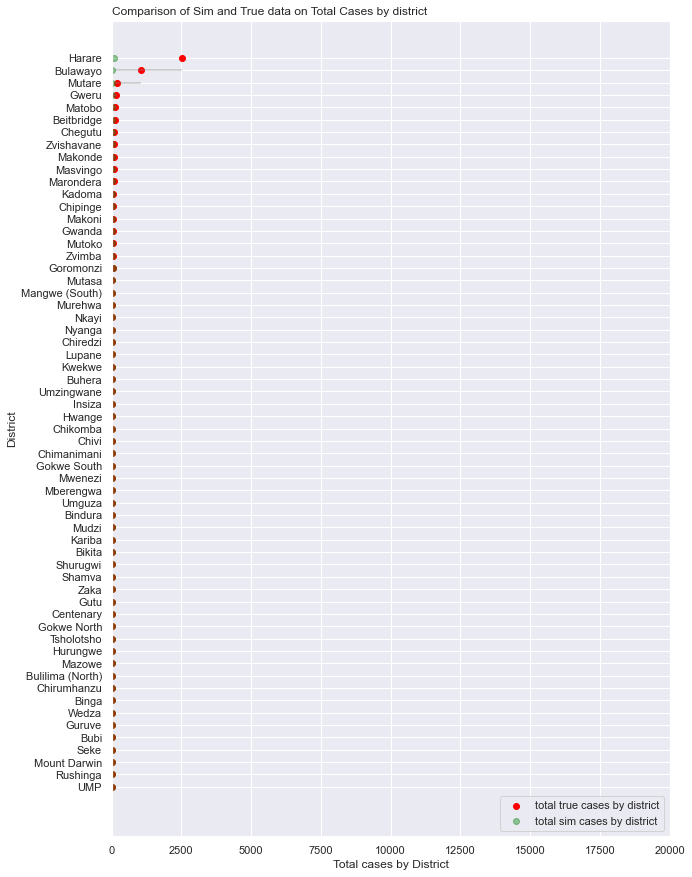

In [22]:
# Reorder it following the values of the first value:
ordered_df = dist_true_plus_sim.sort_values(by='true_cases_by_dist')
#ordered_df = dist_true_plus_sim[['districtId', 'true_cases_by_dist', 'sim_tot_cases_dist_med']]

my_range=range(1,len(dist_true_plus_sim.index)+1)
fig, ax = plt.subplots (figsize = (10, 15))

# The horizontal plot is made using the hline function
plt.hlines(y=ordered_df['district_name_shpfile'], xmin=ordered_df['true_cases_by_dist'], xmax=ordered_df['sim_tot_cases_dist'], color='grey', alpha=0.4)
plt.scatter(ordered_df['true_cases_by_dist'], my_range, color='red', alpha=1, label='total true cases by district')
plt.scatter(ordered_df['sim_tot_cases_dist'], my_range, color='green', alpha=0.4 , label='total sim cases by district')
plt.legend(loc='lower right')
 
# Add title and axis names
plt.yticks(my_range, ordered_df['district_name_shpfile'])
plt.title("Comparison of Sim and True data on Total Cases by district", loc='left')
plt.xlabel('Total cases by District')
plt.ylabel('District')

#limit range on axis
plt.xlim([0, 20000])

# Show the graph
#plt.savefig(path+'plots/district/lolipop_plots/tot_cases_dists_sim_vs_true_exclHarare.png')



Text(0, 0.5, 'District')

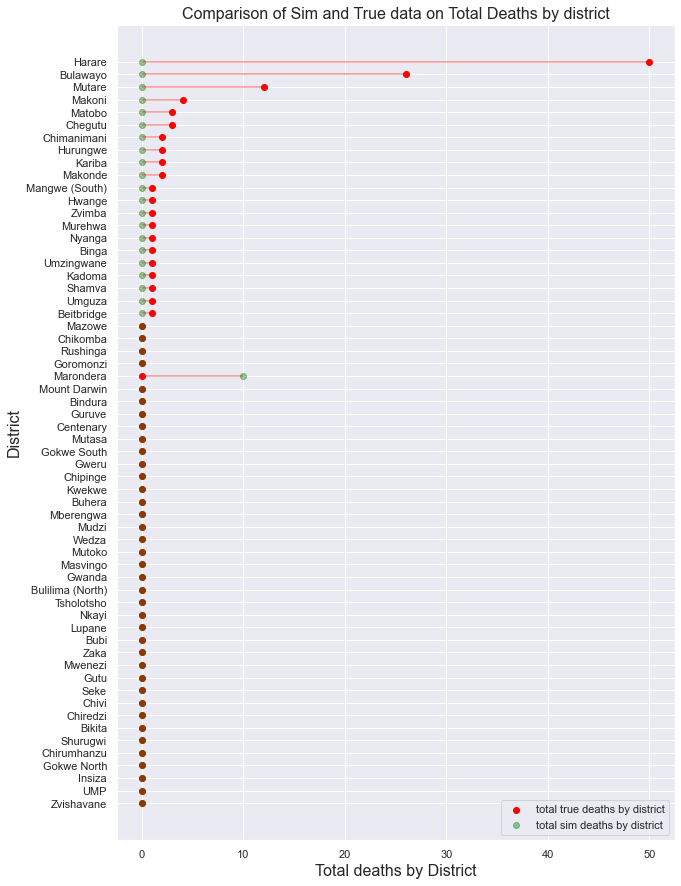

In [28]:
# Reorder it following the values of the first value:
ordered_df = dist_true_plus_sim.sort_values(by='true_deaths_by_dist')
#ordered_df = dist_true_plus_sim[['districtId', 'true_cases_by_dist', 'sim_tot_cases_dist_med']]

my_range=range(1,len(dist_true_plus_sim.index)+1)
fig, ax = plt.subplots (figsize = (10, 15))

# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=ordered_df['true_deaths_by_dist'], xmax=ordered_df['sim_tot_deaths_dist'], color='red', alpha=0.4)
plt.scatter(ordered_df['true_deaths_by_dist'], my_range, color='red', alpha=1, label='total true deaths by district')
plt.scatter(ordered_df['sim_tot_deaths_dist'], my_range, color='green', alpha=0.4 , label='total sim deaths by district')
plt.legend(loc='lower right')
 
# Add title and axis names
plt.yticks(my_range, ordered_df['district_name_shpfile'])
plt.title("Comparison of Sim and True data on Total Deaths by district", loc='center', size = 16)
plt.xlabel('Total deaths by District', size = 16)
plt.ylabel('District', size = 16)

# Show the graph
#plt.savefig(path+'plots/district/box_plots/tot_deaths_dists_sim_vs_true.png')



### 4. Visualize the actual case data versus the model simulation

In [35]:
from os.path import isfile, join
gd_path = '/Users/sophieayling/Google Drive/PhD/10_validation/'
gh_path = '/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\calibration_data/'

In [37]:
# import the data
df_cases = pd.read_stata(gd_path + 'national_cases_by_day.dta')
df_deaths = pd.read_stata(gd_path + 'national_deaths_by_day.dta')
df_deaths.head()

,date,deaths_by_day
0,2020-03-20,1.0
1,2020-03-24,0.0
2,2020-03-25,0.0
3,2020-03-27,0.0
4,2020-03-30,0.0


In [38]:
real_data= df_cases.set_index('date').join(df_deaths.set_index('date'))


# create a date range including each day and match back to this
all_dates= pd.date_range(start='2020-03-20', end='2020-09-01')
all_dates= all_dates.to_frame(index=True, name ='dated')
all_dates.index.name = 'date'
#all_dates.head()
#real_data.head()
real_data=real_data.reset_index()
real_data.head()
real_data.to_csv(path_output+'real_data_comb.csv')

In [39]:
comb_data=all_dates.join(real_data.set_index('date'), on='date')
comb_data = comb_data.fillna(0)
comb_data['cum_deaths']=comb_data['deaths_by_day'].cumsum()
comb_data=comb_data.drop(columns=['dated'])
comb_data=comb_data.reset_index()
comb_data.to_csv(path_output+'comb_data.csv')
comb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 4 columns):
date             166 non-null datetime64[ns]
cases_by_day     166 non-null float32
deaths_by_day    166 non-null float32
cum_deaths       166 non-null float32
dtypes: datetime64[ns](1), float32(3)
memory usage: 3.4 KB


/opt/anaconda3/envs/covid19_abm/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


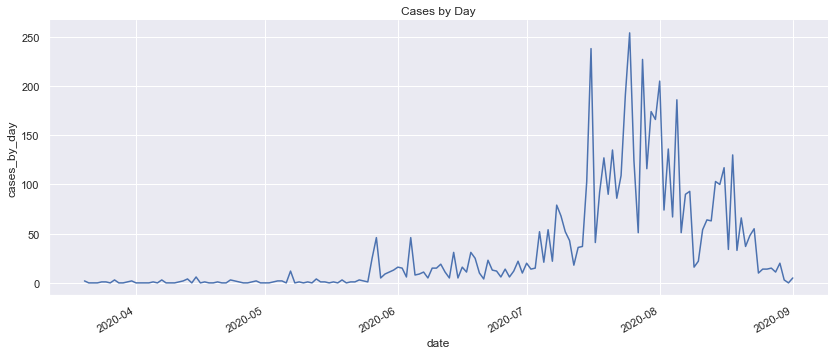

In [40]:
#take a look at case data

g=sns.relplot(x="date", y="cases_by_day", kind="line", data=comb_data).set(title="Cases by Day")
g.fig.set_figwidth(13,4)
g.fig.autofmt_xdate()

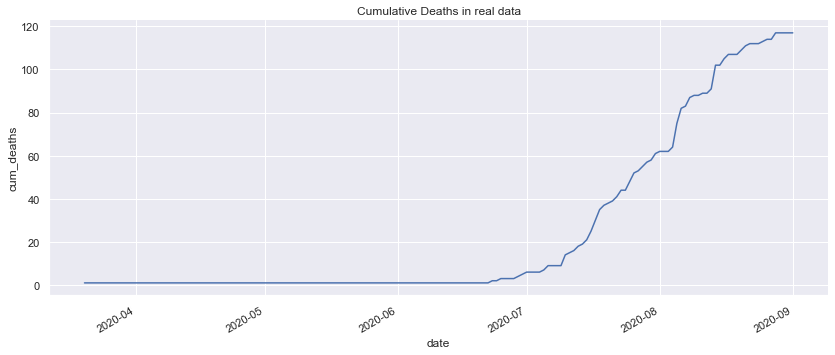

In [41]:
# take a look at death data
g = sns.relplot(x="date", y="cum_deaths", kind="line", data=comb_data).set(title="Cumulative Deaths in real data")
g.fig.set_figwidth(13,4)
g.fig.autofmt_xdate()

In [42]:
r_data.head()

,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,Unnamed: 8,districtId
0,0,d_38,0,0,0,0,0,0,NaN,38
1,0,d_39,0,0,0,0,0,0,NaN,39
2,0,d_47,0,0,0,0,0,0,NaN,47
3,0,d_48,0,0,0,7,3,0,NaN,48
4,0,d_45,0,0,0,0,0,0,NaN,45


In [43]:
# create the national cases and cumulative deaths by day equivalent
nat_daily_sim = r_data.groupby(['time']).agg({'metric_new_cases_sympt':np.sum, 'metric_new_deaths':np.sum, 'metric_died_count':np.sum})
nat_daily_sim.head()
nat_daily_sim.to_csv(path_output+'nat_daily_sim.csv')
## need to figure out why metric_new_cases_sypt seems to be non cumulative but the other is cumulative
nat_daily_sim

,metric_new_cases_sympt,metric_new_deaths,metric_died_count
time,,,
0,49,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
156,4,0,1
157,1,0,1
158,2,0,1


In [44]:
# join the real and sim data
real_plus_sim=pd.concat([nat_daily_sim, comb_data], axis=1)

# create a scaled up variable of cases and deaths x20
real_plus_sim['scaled_sim_cases']=real_plus_sim['metric_new_cases_sympt']
real_plus_sim['scaled_sim_deaths']=real_plus_sim['metric_new_deaths' ] 
real_plus_sim['scaled_cum_deaths']=real_plus_sim['metric_died_count']


# create the cumulative variable for sim deaths
real_plus_sim['cum_deaths_sim']=real_plus_sim['metric_new_deaths'].cumsum()
real_plus_sim['cum_deaths_sim_scaled']=real_plus_sim['scaled_sim_deaths'].cumsum()
## strictly speaking this is not necessary because we have the diedcount variable. keeping this code here as useful ref.

real_plus_sim= real_plus_sim[['date', 'cases_by_day', 'metric_new_cases_sympt', 'scaled_sim_cases', 'deaths_by_day', 'cum_deaths', 'metric_new_deaths', 'metric_died_count', 'scaled_sim_deaths', 'cum_deaths_sim', 'cum_deaths_sim_scaled']] 
real_plus_sim.to_csv(path_output+'real_plus_sim_'+ output_filename +'.csv')
real_plus_sim.index.name="time"
real_plus_sim.head()


,date,cases_by_day,metric_new_cases_sympt,scaled_sim_cases,deaths_by_day,cum_deaths,metric_new_deaths,metric_died_count,scaled_sim_deaths,cum_deaths_sim,cum_deaths_sim_scaled
time,,,,,,,,,,,
0,2020-03-20,2.0,49.0,49.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2020-03-21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2020-03-22,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2020-03-23,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2020-03-24,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


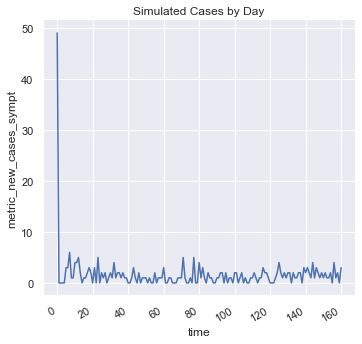

In [45]:
g = sns.relplot(x="time", y="metric_new_cases_sympt", kind="line", data=real_plus_sim).set(title="Simulated Cases by Day")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_cases_'+ output_filename + '.png')

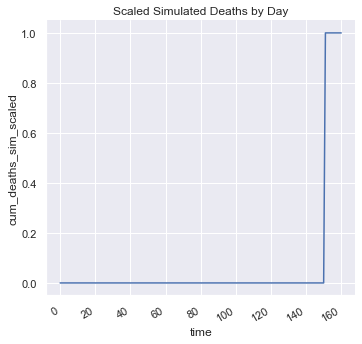

In [46]:
g = sns.relplot(x="time", y="cum_deaths_sim_scaled", kind="line", data=real_plus_sim).set(title="Scaled Simulated Deaths by Day")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_scaled_deaths_'+output_filename +'.png')

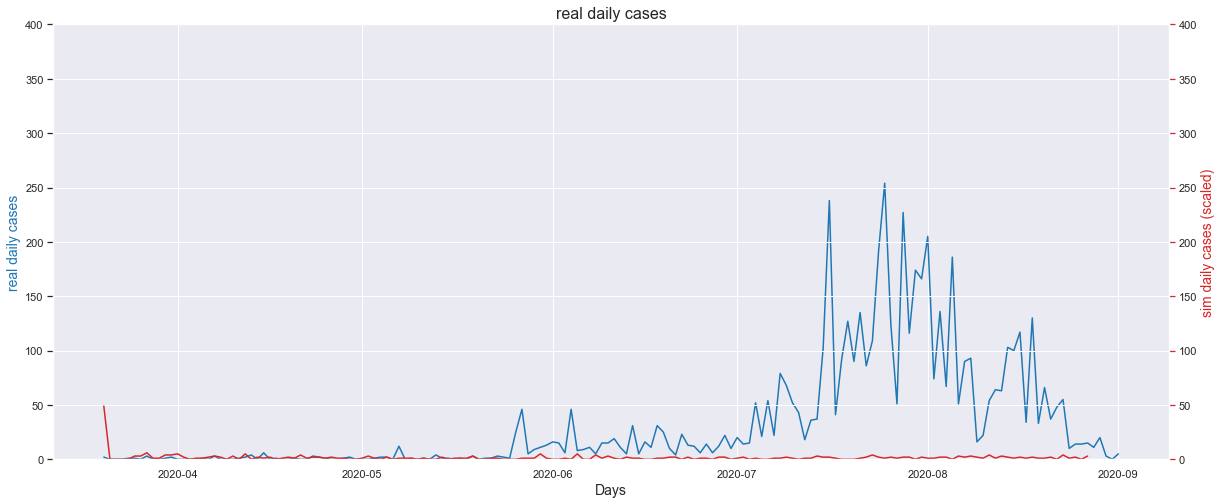

In [47]:

fig, ax1 = plt.subplots(figsize=(20,8))
color = 'tab:blue'
#real data creation
ax1.set_title('real daily cases', fontsize=16)
ax1.set_xlabel('Days', fontsize= 14)
ax1.set_ylabel('real daily cases', fontsize=14, color= color)
ax1= sns.lineplot(x='date', y='cases_by_day', data=real_plus_sim, ci=None, color=color, legend='auto')
ax1.tick_params(axis='y')
ax1.set_ylim([0,400])

#specify we want to share the same x axis
ax2 = ax1.twinx()

color = 'tab:red'
#line plot creation for sim data
ax2.set_ylabel('sim daily cases (scaled)', fontsize=14, color=color)
ax2 = sns.lineplot(x='date', y='scaled_sim_cases', data=real_plus_sim, ci=None, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
ax2.set_ylim([0,400])
#show plot
fig.savefig('../data/output/plots/sim_scaled_plus_real_cases_' + output_filename + '.png')

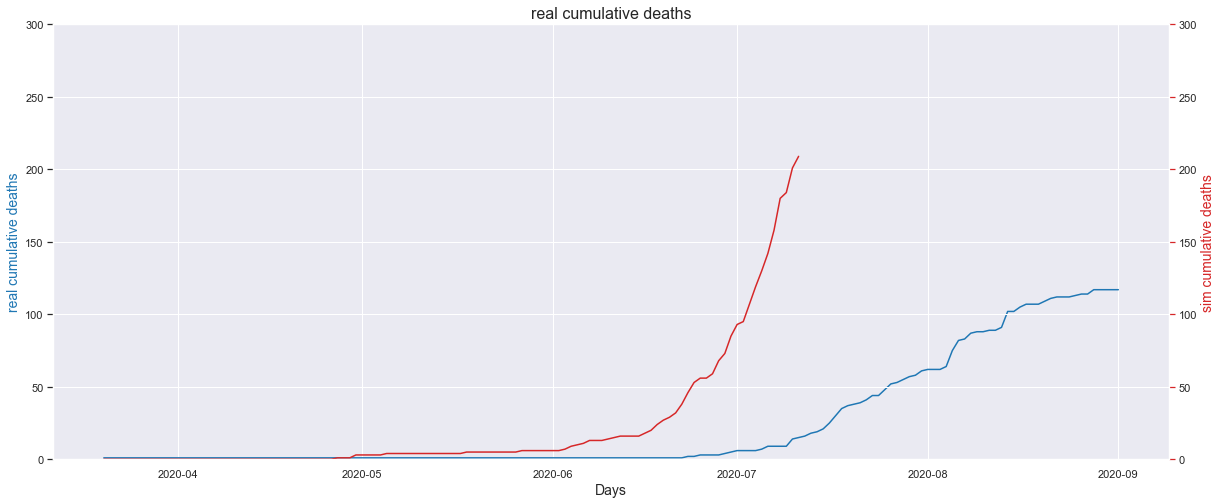

In [74]:
# Same type of plot for cumulative deaths in sim versus reality

fig, ax1 = plt.subplots(figsize=(20,8))
color = 'tab:blue'
#real data creation
ax1.set_title('real cumulative deaths', fontsize=16)
ax1.set_xlabel('Days', fontsize= 14)
ax1.set_ylabel('real cumulative deaths', fontsize=14, color= color)
ax1= sns.lineplot(x='date', y='cum_deaths', data=real_plus_sim, ci=None, color=color, legend='auto')
ax1.tick_params(axis='y')
ax1.set_ylim([0,300])

#specify we want to share the same x axis
ax2 = ax1.twinx()

color = 'tab:red'
#line plot creation for sim data
ax2.set_ylabel('sim cumulative deaths', fontsize=14, color=color)
ax2 = sns.lineplot(x='date', y='cum_deaths_sim_scaled', data=real_plus_sim, ci=None, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
ax2.set_ylim([0,300])
#show plot
fig.savefig('../data/output/plots/sim_plus_real_deaths_'+output_filename+'.png')